# CSC4008 Project Outline
作业分为如下部分：
- 数据描述与清洗
- 复原教授论文中的K-means 简单说明消费者确实存在分类现象
- 计算每个消费者的marginal consumer impact（MCI）
- 利用MCI标注出部分可能位于同一cluster中的消费者，利用similarity矩阵的补全完成分类，（这玩意甚至是robust的，outlier不会被归类）
- 比较这种分类和K-means，教授的简单一维MCI分类的异同


## 1. 数据描述与清洗
数据总共有三列：日期与时间，用户ID，用户在对应时间内的用电量。
用户的数据记录数可以不同，这说明存在一部分用户在某部分时间中的消费是未被记录的（缺失值）。

用户总数为346。
每个用户的记录数量见consumer_counts.txt


In [9]:
import pandas as pd

# read in dataset
df1 = pd.read_csv("dataset/pecan_1_min_part1.csv")
df2 = pd.read_csv("dataset/pecan_1_min_part2.csv")
df3 = pd.read_csv("dataset/pecan_1_min_part3.csv")
df4 = pd.read_csv("dataset/pecan_1_min_part4.csv")
df5 = pd.read_csv("dataset/pecan_1_min_part5.csv")
df6 = pd.read_csv("dataset/pecan_1_min_part6.csv")
df7 = pd.read_csv("dataset/pecan_1_min_part7.csv")
df8 = pd.read_csv("dataset/pecan_1_min_part8.csv")
df9 = pd.read_csv("dataset/pecan_1_min_part9.csv")
df10 = pd.read_csv("dataset/pecan_1_min_part10.csv")
df11 = pd.read_csv("dataset/pecan_1_min_part11.csv")

# print(df1.head())
# print(df1['dataid'].value_counts())

# count number of costumers
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11])
print(df['dataid'].value_counts())

# 346 consumers

4874    173100
2158    173100
1551    173100
1617    173100
1632    173100
         ...  
3734     86400
1796     85680
9295     46520
9836      4760
9333      4760
Name: dataid, Length: 346, dtype: int64


数据的第一列是时间。数据清洗的第一步是将时间设为index，方便后期提取每日的电力消费数据。

（此处参考 pandas：时间序列与日期用法）
```python
# 去除时区
df['localminute'] = df['localminute'].map(lambda x: str(x)[:-3])

# 字符串时间数据转换为时间戳
df['localminute'] = pd.to_datetime(df['localminute'])
df.set_index("localminute", inplace=True)

# 查看每日电力总消耗
print(df.resample('D').sum()) 

                     dataid    use
localminute                       
2016-01-01 00:00:00      26  0.519
2016-01-01 00:00:00      59  1.176
2016-01-01 00:00:00      86  0.469
2016-01-01 00:00:00     114  1.006
2016-01-01 00:00:00     370  0.519
...                     ...    ...
2016-03-04 01:19:00    9235  0.309
2016-03-04 01:19:00    9654  0.202
2016-03-04 01:20:00    8317  0.634
2016-03-04 01:20:00    9134  0.884
2016-03-04 01:20:00    8829  0.507

[49443400 rows x 2 columns]
                 dataid         use
localminute                        
2016-01-01   2427274080  546607.568
2016-01-02   2427274080  553381.135
2016-01-03   2427184744  512692.356
2016-01-04   2427274080  513023.177
2016-01-05   2427274080  510770.283
...                 ...         ...
2016-04-26    720524160  371784.480
2016-04-27    720524160  350438.062
2016-04-28    720416400  356966.016
2016-04-29    716495760  369063.316
2016-04-30    126155394   51086.188

[121 rows x 2 columns]
```

数据采集的最小间隔是分钟。一条数据就是某用户在当天的某一分钟内的电力消费。
```python
print(df1[df1['dataid'] == 26]) # 查看26号用户的记录

dataid    use
localminute                       
2016-01-01 00:00:00      26  0.519
2016-01-01 00:01:00      26  0.519
2016-01-01 00:02:00      26  0.518
2016-01-01 00:03:00      26  0.519
2016-01-01 00:04:00      26  0.518
...                     ...    ...
2016-04-30 04:37:00      26  0.510
2016-04-30 04:38:00      26  0.538
2016-04-30 04:39:00      26  0.506
2016-04-30 04:40:00      26  0.000
2016-04-30 04:41:00      26  0.000

[173022 rows x 2 columns]

Process finished with exit code 0

```
文件 用户数据量统计.txt中有所有用户的在1月1日到4月29日的数据量统计。（截掉4月30号的记录，从上面26号用户的记录末尾可以看出4月30号数据不全）
多数用户数据量为172740分钟，比1月1日到4月29日的总时间172800分钟少了60分钟。似乎是因为3月13号凌晨两点的数据缺失。




In [8]:
# 去除时区
df['localminute'] = df['localminute'].map(lambda x: str(x)[:-3])

# 字符串时间数据转换为时间戳
df['localminute'] = pd.to_datetime(df['localminute'])
df.set_index("localminute", inplace=True)

# 查看每日电力总消耗
print(df.resample('D').sum())  



                     dataid    use
localminute                       
2016-01-01 00:00:00      26  0.519
2016-01-01 00:00:00      59  1.176
2016-01-01 00:00:00      86  0.469
2016-01-01 00:00:00     114  1.006
2016-01-01 00:00:00     370  0.519
...                     ...    ...
2016-03-04 01:19:00    9235  0.309
2016-03-04 01:19:00    9654  0.202
2016-03-04 01:20:00    8317  0.634
2016-03-04 01:20:00    9134  0.884
2016-03-04 01:20:00    8829  0.507

[49443400 rows x 2 columns]
                 dataid         use
localminute                        
2016-01-01   2427274080  546607.568
2016-01-02   2427274080  553381.135
2016-01-03   2427184744  512692.356
2016-01-04   2427274080  513023.177
2016-01-05   2427274080  510770.283
...                 ...         ...
2016-04-26    720524160  371784.480
2016-04-27    720524160  350438.062
2016-04-28    720416400  356966.016
2016-04-29    716495760  369063.316
2016-04-30    126155394   51086.188

[121 rows x 2 columns]


## 2. 简单的K-means分类
能做就做，不能做直接搬老师论文开头的结论。

## 3. 计算MCI
这一步非常关键。

老师在论证MCI定价的时候顺带提了一下efficiency。这块可以联系经济学知识填充一下pre内容。
第i个用户在某天时段$t = 1,...,T$内的MCI与价格的关系如下：
$$
MCI_i = \sum_{t=1}^{T} p(t) \frac{l_i^t}{||Li||_1}
$$

MCI的具体计算如下：
（上标为时刻，下标为用户名）
假设用户总人数为$N$，数据采集自一个连续时段$(1,2,...,T)$。第i个用户在该时段内的能源消费记录为$L_i = (l_i^1,...,l_i^T)$。
系统在t时刻的总能源消耗为$L^t = \sum_{i =1}^{N} l_i^t$。
系统的总能源消费记录为$L = (L^1,...,L^T)$
假设生产$L$单位的能源的金钱花费有如下关系：

$$
C(L) = {1 \over 2} a L^2 + bL + c
$$
那么，第i位用户的MCI为：

$$
\begin{aligned}
 MCI_i &= \lim_{\Delta \rightarrow 0} \frac{C(L + \frac{\Delta L_i}{||L_i||_1}) - C(L)}{\Delta} \\
 &= \lim_{\Delta \rightarrow 0}\frac{\sum_{t=1}^T(aL^t + b)\frac{\Delta l_i^t}{||l_i||_1} + \left(  \frac{\Delta l_i^t}{||l_i||_1}   \right)^2 }{\Delta} \\
 &= \sum_{t=1}^T (aL^t + b)\frac{ l_i^t}{||l_i||_1} 
 \end{aligned}
$$
 注意$p(t) = (aL^t + b)$，定价时让价格等于marginal cost，可以达到pareto efficiency。
 
一个小问题是如何确定$C(L)$中的系数a，b。不过这个系数的问题应该不重要。下面取A=100，B=20，计算26号顾客在2016-01-01当天的MCI
```python
df_1day = df1['2016-01-01']

print("1-Minute total electricity consumption: ")
print(df_1day.resample('1Min').sum())

print("id = 26 consumer's 1-minute consumption: ")
print( sum(df_1day[df_1day['dataid'] == 26]['use']) )

A = 100
B = 20
print('MCI = ')
print(sum( (A * (df_1day.resample('1Min').sum())['use'] + B) * df_1day[df_1day['dataid'] == 26]['use'] / sum(df_1day[df_1day['dataid'] == 26]['use']) ) )
```



## 4. 矩阵补全分类
用矩阵$S$做如下表示：$S(i,j) = 0$表示i，j不在一类中，$S(i,j) = 1$表示i，j在一类中。默认$S(i,i) = 1$,即一个元素和它本身在同一类中。

假设我们有三个元素$\{1,2,3\}$，分类成两类$\{1,3\},\{2\}$。
$$
S = \begin{bmatrix} 
1&0&1\\0&1&0\\1&0&1
\end{bmatrix}
$$

我们发现，矩阵S的rank即为种类的数量。





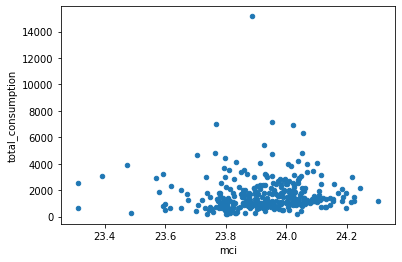

In [2]:
import pandas as pd

user_df = pd.read_csv("user_data.csv")
user_df.plot.scatter(x='mci', y='total_consumption')
